## pix2pix(U-Net + GAN) experiments

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

### Model definitions

In [2]:
from utils import load_dataset, save_p2p_models, load_p2p_models
from utils import plot_p2p_models, plot_p2p_losses, gen_nn_output
from utils import three_image_generators
from models import g_unet, discriminator, pix2pix
from train import train

Using TensorFlow backend.


### Dataset loading + preprocessing

In [3]:
W = 256
H = 256
dataset_path = '../data/sand'
trend_num = 3
side1_train, side2_train, panorama_train, side1_val, side2_val, panorama_val, N_train, N_val = load_dataset(
    dataset_path, trend_num=trend_num, mode=3, W=W, H=H)

Validation dataset: 100%|██████████| 175/175 [00:13<00:00, 11.83it/s]


In [4]:
batch_size = 20
train_gen, val_gen = three_image_generators(
    side1_train, side2_train, panorama_train, side1_val, side2_val, panorama_val, batch_size=batch_size)

### Training

In [5]:
models_path = 'trained_models/sand'
trend_num = 3
nn_name = 'nf32_woUnet'

In [6]:
# создание моделей
nf = 32
f_gen = g_unet(nf)
d = discriminator(nf)
p2p = pix2pix(f_gen, d)
#plot_p2p_models(models_path, trend_num, nn_name, f_gen, d, p2p)
#tbCallback = create_tb_callback(models_path, trend_num, nn_name)

In [ ]:
# обучение
losses = train(f_gen, d, p2p, train_gen, val_gen, epochs=150,
               train_samples=N_train, val_samples=N_val, batch_size=batch_size)
save_p2p_models(models_path, trend_num, nn_name, f_gen, d, losses)

Epoch 1/1
67/67 [==============================] - 61s - loss: 0.0625    
Epoch 1/1
67/67 [==============================] - 66s - loss: 67.6684    

Dir already exist
Models saved successfully


### Trained NN

In [7]:
f_gen, d, losses = load_p2p_models(models_path, trend_num, nn_name)
p2p = pix2pix(f_gen, d)

/home/ysbudakyan/anaconda3/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: ('Unknown loss function', ':d_loss')

In [10]:
f_gen.load_weights('trained_models/sand/trend3/nf32_woUnet/f_gen.weights')

In [ ]:
plot_p2p_losses(models_path, trend_num, nn_name, losses)

In [11]:
s1, s2, pan, gen = gen_nn_output(models_path, trend_num, nn_name, f_gen, val_gen, 10, W, H)

Dir already exist
NN output saved successfully.


In [14]:
pan.shape

AttributeError: 'list' object has no attribute 'shape'

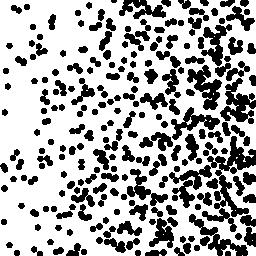

In [13]:
pan[1]

In [16]:
side1, side2, p = next(train_gen)

In [19]:
tensor = f_gen.predict(np.concatenate((side1, side2), axis=3))

In [20]:
tensor.shape

(20, 256, 256, 1)

In [21]:
tensor1 = tensor[1]
tensor2 = tensor[2]

In [24]:
tensor1_rsh = tensor1.reshape(256, 256)
tensor2_rsh = tensor2.reshape(256, 256)

In [34]:
sample1 = (127.5 * tensor1_rsh + 127.5).astype('uint8')
sample2 = (127.5 * tensor2_rsh + 127.5).astype('uint8')

In [35]:
sample1

array([[254, 254, 254, ..., 253, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ..., 
       [253, 250, 244, ...,   1,  15, 110],
       [252, 249, 242, ...,   0,   0, 100],
       [252, 250, 245, ...,   9,  20, 152]], dtype=uint8)

In [36]:
sample2

array([[254, 254, 254, ..., 253, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ..., 
       [253, 250, 244, ...,   1,  15, 110],
       [252, 249, 242, ...,   0,   0,  99],
       [252, 250, 245, ...,   9,  19, 150]], dtype=uint8)

In [37]:
from PIL import Image
image = Image.fromarray(sample1, mode='L')

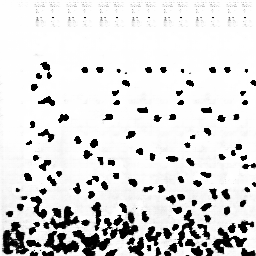

In [38]:
image

In [42]:
image2 = Image.fromarray((127.5 * p[1].reshape(256, 256) + 127.5).astype('uint8'))

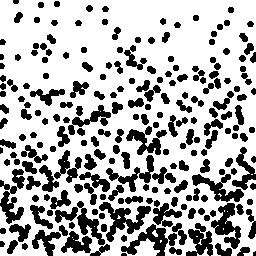

In [43]:
image2